https://www.last.fm

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# скачано отсюда:
# http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-360K.tar.gz
DATA_DIR="/data/lastfm-dataset-360K/"

In [2]:
!ls {DATA_DIR}

README.txt	 usersha1-artmbid-artname-plays.tsv
mbox_sha1sum.py  usersha1-profile.tsv


In [3]:
# в основном файле четыре колонки, разделённых табуляциями, без заголовка
!head {DATA_DIR}/usersha1-artmbid-artname-plays.tsv

00000c289a1829a808ac09c00daf10bc3c4e223b	3bd73256-3905-4f3a-97e2-8b341527f805	betty blowtorch	2137
00000c289a1829a808ac09c00daf10bc3c4e223b	f2fb0ff0-5679-42ec-a55c-15109ce6e320	die ��rzte	1099
00000c289a1829a808ac09c00daf10bc3c4e223b	b3ae82c2-e60b-4551-a76d-6620f1b456aa	melissa etheridge	897
00000c289a1829a808ac09c00daf10bc3c4e223b	3d6bbeb7-f90e-4d10-b440-e153c0d10b53	elvenking	717
00000c289a1829a808ac09c00daf10bc3c4e223b	bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8	juliette & the licks	706
00000c289a1829a808ac09c00daf10bc3c4e223b	8bfac288-ccc5-448d-9573-c33ea2aa5c30	red hot chili peppers	691
00000c289a1829a808ac09c00daf10bc3c4e223b	6531c8b1-76ea-4141-b270-eb1ac5b41375	magica	545
00000c289a1829a808ac09c00daf10bc3c4e223b	21f3573f-10cf-44b3-aeaa-26cccd8448b5	the black dahlia murder	507
00000c289a1829a808ac09c00daf10bc3c4e223b	c5db90c4-580d-4f33-b364-fbaa5a3a58b5	the murmurs	424
00000c289a1829a808ac09c00daf10bc3c4e223b	0639533a-0402-40ba-b6e0-18b067198b73	lunachicks	403


In [4]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .master("local[*]")
    .getOrCreate()
)

In [5]:
import os
import pyspark.sql.functions as sql_func

plays = (
    spark
    .read
    .csv(
        os.path.join(DATA_DIR, "usersha1-artmbid-artname-plays.tsv"),
        header=False,
        inferSchema=True,
        sep='\t'
    )
    .sample(withReplacement=False, fraction=1.0, seed=42)
    # имена колоном можно узнать из файла README.txt
    .toDF("user", "artist", "artist_name", "plays")
    .cache()
)

In [6]:
# этот набор данных гораздо более разреженный, чем movielens
total_users = plays.select("user").distinct().count()
total_artists = plays.select("artist_name").distinct().count()
total_samples = plays.count()
print("всего пользователей:", total_users)
print("всего исполнителей:", total_artists)
print("всего пар пользователь-исполнитель:", total_samples)
print("процент ненулевых пар:", total_samples / total_users / total_artists)

всего пользователей: 359349
всего исполнителей: 292577
всего пар пользователь-исполнитель: 17559530
процент ненулевых пар: 0.00016701530241348985


In [7]:
# в отличие от movielens, количества прослушиваний имеют гораздо больший размах
plays.select("plays").describe().show()

+-------+------------------+
|summary|             plays|
+-------+------------------+
|  count|          17559518|
|   mean|215.18542764100928|
| stddev|   614.44796397153|
|    min|               0.0|
|    max|          419157.0|
+-------+------------------+



In [8]:
# есть какие-то пользователи, совершившие меньше одного прослушивания
plays.where("plays < 1").show(truncate=False)

+----------------------------------------+------+-----------+-----+
|user                                    |artist|artist_name|plays|
+----------------------------------------+------+-----------+-----+
|cbec2d2763c856034f5689ba13ca8addb9d24984|null  |28         |0.0  |
+----------------------------------------+------+-----------+-----+



In [9]:
# давайте посмотрим на распределение длин идентификаторов
plays.select(sql_func.length("artist").alias("l")).distinct().orderBy("l").show()

+----+
|   l|
+----+
|null|
|   2|
|   3|
|  15|
|  35|
|  36|
|  37|
+----+



In [10]:
# исполнители курильщика
plays.where("LENGTH(artist) < 35").select("artist", "artist_name").distinct().show()

+---------------+--------------+
|         artist|   artist_name|
+---------------+--------------+
|            211| 000 promises.|
|rock / a30a400a|blind the fold|
|            313|    000 things|
|             96|    000 things|
+---------------+--------------+



In [11]:
# исполнители здорового человека
plays.where("LENGTH(artist) >= 35").select("artist").distinct().show(truncate=False, n=5)

+------------------------------------+
|artist                              |
+------------------------------------+
|ada7a83c-e3e1-40f1-93f9-3e73dbc9298a|
|02fc3032-e491-46b8-8742-9859e4906dcc|
|0a77bec1-12ef-4caa-b36a-f533001fcd29|
|debabff3-2559-46e5-862d-ef2a906d7010|
|d547b148-cf1f-421b-9464-ce7411ba44b8|
+------------------------------------+
only showing top 5 rows



In [12]:
# аналогичные странности есть с ID пользователя
plays.select(sql_func.length("user")).distinct().show()

+------------+
|length(user)|
+------------+
|          12|
|          40|
+------------+



In [13]:
# идентификаторы длины 12 выглядят странно
plays.where("LENGTH(user) == 12").select("user").distinct().show()

+------------+
|        user|
+------------+
|sep 20, 2008|
|dec 27, 2008|
+------------+



In [14]:
# будем в дальнейшем использовать очищенное множество
pure_plays = (
    plays
    .where("LENGTH(artist) >= 35 AND LENGTH(user) == 40")
    .cache()
)
pure_plays.select("plays").describe().show()

+-------+-----------------+
|summary|            plays|
+-------+-----------------+
|  count|         17332977|
|   mean|216.0470919681022|
| stddev| 616.996942719551|
|    min|              1.0|
|    max|         419157.0|
+-------+-----------------+



In [15]:
# для неявной обратной связи в таком виде обычно хорошо работает
# логарифмическая шкала
pure_plays.select(sql_func.log("plays")).describe().show()

+-------+------------------+
|summary|        LOG(plays)|
+-------+------------------+
|  count|          17332977|
|   mean| 4.426035251429405|
| stddev|1.4618746810751018|
|    min|               0.0|
|    max| 12.94600083039178|
+-------+------------------+



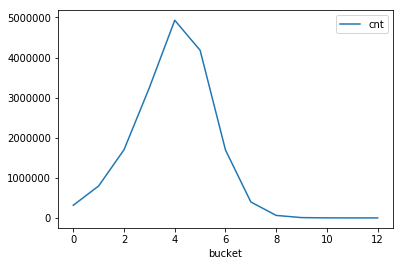

In [16]:
# распределение логарифма количества прослушиваний
(
    pure_plays
    .select(sql_func.floor(sql_func.log("plays")).alias("bucket"))
    .groupBy("bucket")
    .agg(sql_func.count("bucket").alias("cnt"))
    .orderBy("bucket")
    .toPandas()
    .plot(x="bucket", y="cnt")
)

In [17]:
# выберем самых популярных исполнителей
top_artists = (
    pure_plays
    .groupBy("artist", "artist_name")
    .agg(sql_func.sum("plays").alias("total_plays"))
    .orderBy(sql_func.desc("total_plays"))
    .limit(100)
    .toPandas()
)
top_artists.head()

,artist,artist_name,total_plays
0,b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d,the beatles,30499140.0
1,a74b1b7f-71a5-4011-9441-d0b5e4122711,radiohead,27452124.0
2,cc197bad-dc9c-440d-a5b5-d52ba2e14234,coldplay,16701858.0
3,83d91898-7763-47d7-b03b-b92132375c47,pink floyd,15965959.0
4,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,metallica,15498759.0


In [18]:
# посчитаем hitrate@N
def hitrate_at_n(n: int) -> float:
    return (
        pure_plays
        .join(
            sql_func.broadcast(spark.createDataFrame(top_artists[:n])),
            on="artist",
            how="left"
        )
        .groupBy("user")
        .agg(sql_func.max("total_plays").alias("some_plays"))
        .select(
            sql_func.col("user"),
            sql_func.when(sql_func.col("some_plays").isNotNull(), 1).otherwise(0).alias("hit")
        )
        .agg(sql_func.avg("hit").alias("hit_rate"))
        .first()[0]
    )

In [19]:
# чем больше элементов мы можем порекомендовать, тем лучше метрики
for n in [100, 50, 20, 10, 5, 1]:
    print("hitrate@{} = {}".format(n, hitrate_at_n(n)))

hitrate@100 = 0.9254293323537515
hitrate@50 = 0.869095027787286
hitrate@20 = 0.7547928546183666
hitrate@10 = 0.6508709094805155
hitrate@5 = 0.5333739637165112
hitrate@1 = 0.21251638434116163
